#  Visão Computacional e Deep Learning - facenet

base de dados: LFW

#### Importando as bibliotecas necessárias

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from mtcnn.mtcnn import MTCNN

%matplotlib inline

Using TensorFlow backend.
C:\Users\Andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Andre\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
image_size = 160

#### Carregando as imagens de treino e teste

In [7]:
def carrega_imagens(dir_basepath):
    imgs = []
    names = os.listdir(dir_basepath)

    for name in names:
        image_full_path = dir_basepath + name
        for f in os.listdir(image_full_path):
            imgs.append(os.path.join(image_full_path, f))
    return imgs

In [13]:
imgs_train = carrega_imagens('lfw-mini/train/')

In [14]:
imgs_test = carrega_imagens('lfw-mini/test/')


#### Verificando as imagens

In [15]:
for train, test in zip(imgs_train,imgs_test):
    print("{} ------- {}".format(train,test))

lfw-mini/train/Aaron_Peirsol\Aaron_Peirsol_0001.jpg ------- lfw-mini/test/Aaron_Peirsol\Aaron_Peirsol_0002.jpg
lfw-mini/train/Aaron_Sorkin\Aaron_Sorkin_0001.jpg ------- lfw-mini/test/Aaron_Sorkin\Aaron_Sorkin_0002.jpg
lfw-mini/train/Abdel_Nasser_Assidi\Abdel_Nasser_Assidi_0001.jpg ------- lfw-mini/test/Abdel_Nasser_Assidi\Abdel_Nasser_Assidi_0002.jpg
lfw-mini/train/Abdoulaye_Wade\Abdoulaye_Wade_0001.jpg ------- lfw-mini/test/Abdoulaye_Wade\Abdoulaye_Wade_0002.jpg
lfw-mini/train/Abdullah\Abdullah_0001.jpg ------- lfw-mini/test/Abdullah\Abdullah_0002.jpg
lfw-mini/train/Abdullah_al-Attiyah\Abdullah_al-Attiyah_0001.jpg ------- lfw-mini/test/Abdullah_al-Attiyah\Abdullah_al-Attiyah_0002.jpg
lfw-mini/train/Abdullah_Gul\Abdullah_Gul_0001.jpg ------- lfw-mini/test/Abdullah_Gul\Abdullah_Gul_0002.jpg
lfw-mini/train/Abdullatif_Sener\Abdullatif_Sener_0001.jpg ------- lfw-mini/test/Abdullatif_Sener\Abdullatif_Sener_0002.jpg
lfw-mini/train/Abel_Pacheco\Abel_Pacheco_0001.jpg ------- lfw-mini/test/Abel

#### Carregando o modelo do Facenet

In [16]:
model_path = 'model/facenet_keras.h5'
model = load_model(model_path)

W0713 18:45:21.989099  2428 deprecation_wrapper.py:119] From C:\Users\Andre\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 18:45:22.580515  2428 deprecation_wrapper.py:119] From C:\Users\Andre\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 18:45:22.640295  2428 deprecation_wrapper.py:119] From C:\Users\Andre\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 18:45:22.642294  2428 deprecation_wrapper.py:119] From C:\Users\Andre\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0713 18:45:22.643294  2428 deprecation_wrapper.py:119]

#### Carregando o modelo MTCNN para detecção de faces

In [17]:
detector = MTCNN()

#### Funções para detecção de face, resize e calculo de embeddings

In [18]:
def carrega_alinha_imagens(filepath):
    img = imread(filepath)
    faces = detector.detect_faces(img)

    (x, y, w, h) = faces[0]['box']
    img = img[y:y+h,x:x+w,:]
    img_alinhada = [resize(img, (image_size, image_size), mode='reflect')]
    
    img_alinhada = np.array(img_alinhada)
    
    return img_alinhada

In [19]:
def calcula_embedding(filepath, batch_size=1): #1=o batch sera de uma imagem por vez
    img_alinhada = carrega_alinha_imagens(filepath)    
    emb = model.predict_on_batch(img_alinhada[0:1])
    return emb

#### Calculando os embeddings para as imagens de treinamento.

In [20]:
labels_train = []
embs_train = []
for image_filepath in (imgs_train):
    labels_train.append(image_filepath.split('/')[-1].replace('.jpg',''))
    embs_train.append(calcula_embedding(image_filepath))

In [21]:
embs_train = np.concatenate(embs_train)

In [22]:
labels_train = np.array(labels_train)

#### Verificando os shapes.

In [23]:
embs_train.shape

(24, 128)

In [24]:
labels_train.shape

(24,)

#### Calculando os embeddings para as imagens de teste.

In [25]:
labels_test = []
embs_test = []
for image_filepath in (imgs_test):
    labels_test.append(image_filepath.split('/')[-1].replace('.jpg',''))
    embs_test.append(calcula_embedding(image_filepath))

In [26]:
embs_test = np.concatenate(embs_test)

In [27]:
labels_test = np.array(labels_test)

#### Verificando os shapes.

In [28]:
embs_test.shape

(24, 128)

In [29]:
labels_test.shape

(24,)

#### Preparando os dados para rodar o algoritmo de Machine Learning.

##### Aplicando a Normalização nos dados

In [30]:
normalize = Normalizer(norm='l2')
embs_train = normalize.transform(embs_train)
embs_test = normalize.transform(embs_test)

##### Aplicando o Label Encoder para gerar as classes de treino.

In [31]:
le = LabelEncoder().fit(labels_train)

In [32]:
y_train = le.transform(labels_train)

##### Aplicando o Label Encoder para gerar as classes de teste.

In [33]:
le = LabelEncoder().fit(labels_test)

In [34]:
y_test = le.transform(labels_test)

#### Treinando o Classificador SVM.

In [35]:
clf_svm = SVC()

In [36]:
clf_svm.fit(embs_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Avaliando os resultados.

In [37]:
y_pred = clf_svm.predict(embs_test)

In [38]:
accuracy_score(y_test, y_pred)

0.8333333333333334

#### Verificando os resultados de forma visual.

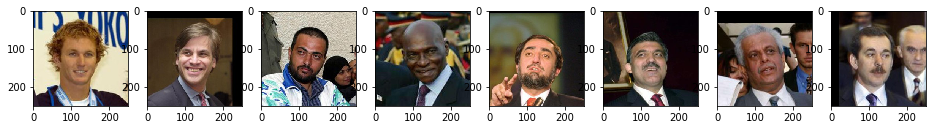

In [39]:
fig, axes = plt.subplots(1,8, figsize=(16, 16))

i = 0

for index in y_test[:8]:
    img = imgs_test[index]
    img = imread(img)
    axes[i].imshow(img)
    i+=1

plt.show()

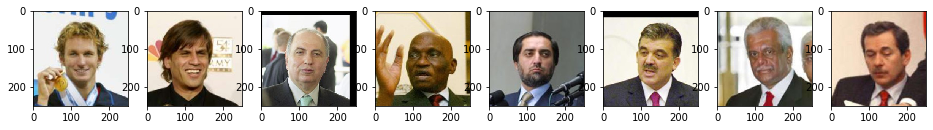

In [40]:
fig, axes = plt.subplots(1,8, figsize=(16, 16))

i = 0

for index in y_pred[:8]:
    img = imgs_train[index]
    img = imread(img)
    axes[i].imshow(img)
    i+=1

plt.show()